In [42]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/animal-faces")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-faces


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
sns.set()

In [44]:
os.listdir('/kaggle/input/animal-faces')

['afhq']

In [45]:
os.listdir('/kaggle/input/animal-faces/afhq')

['val', 'train']

In [46]:
os.listdir('/kaggle/input/animal-faces/afhq/train')

['dog', 'wild', 'cat']

In [47]:
train_images = []
for i in os.listdir('/kaggle/input/animal-faces/afhq/train'):
    for j in os.listdir(os.path.join('/kaggle/input/animal-faces/afhq/train', i)):
        path = os.path.join('/kaggle/input/animal-faces/afhq/train', i, j)
        img = cv2.imread(path)
        if img is None:
            print(path)
        else:
            resized_img = cv2.resize(img, (120, 120))
            train_images.append(resized_img)

In [54]:
val_images = []
for i in os.listdir('/kaggle/input/animal-faces/afhq/val'):
    for j in os.listdir(os.path.join('/kaggle/input/animal-faces/afhq/val', i)):
        path = os.path.join('/kaggle/input/animal-faces/afhq/val', i, j)
        img = cv2.imread(path)
        if img is None:
            print(path)
        else:
            resized_img = cv2.resize(img, (120, 120))
            val_images.append(resized_img)

In [55]:
X_train, X_test = train_test_split(train_images, test_size = 0.2, random_state = 101, shuffle = True)

In [56]:
print(f'Train set size: {len(X_train)} | Test set size: {len(X_test)} | Validation set size: {len(val_images)}')

Train set size: 11704 | Test set size: 2926 | Validation set size: 1500


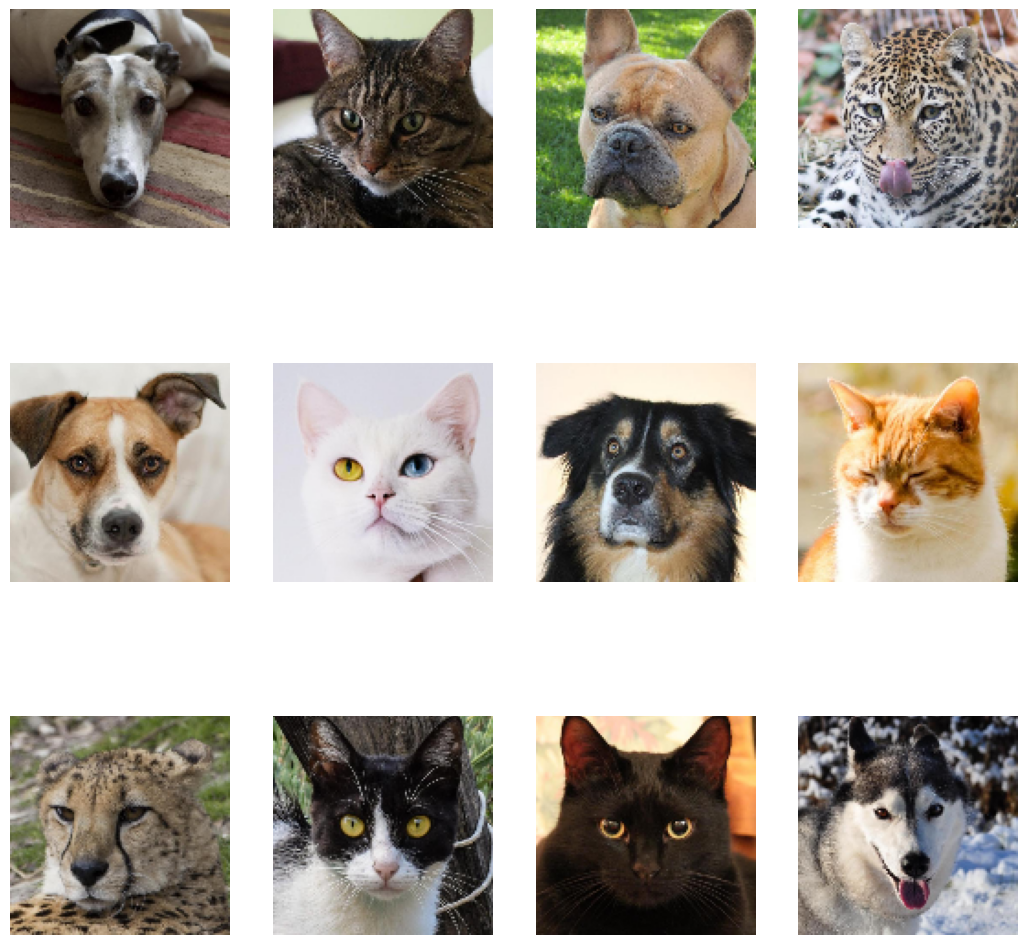

In [58]:
plt.figure(figsize = (13, 13))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    img_rgb = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

In [60]:
X_train_np = np.array(X_train)
X_train_scaled = X_train_np / 255.0

In [62]:
X_test_np = np.array(X_test)
X_test_scaled = X_test_np / 255.0

In [63]:
X_valid_np = np.array(val_images)
X_valid_scaled = X_valid_np / 255.0

In [64]:
def add_noise(img):
    mean = 0
    std_dev_original = 20
    std_dev_scaled = std_dev_original / 255.0
    gaussian_noise = np.random.normal(mean, std_dev_scaled, img.shape)
    noisy_img = img + gaussian_noise
    return noisy_img

In [65]:
noisy_train = add_noise(X_train_scaled)

In [67]:
noisy_test = add_noise(X_test_scaled)

In [68]:
noisy_valid = add_noise(X_valid_scaled)

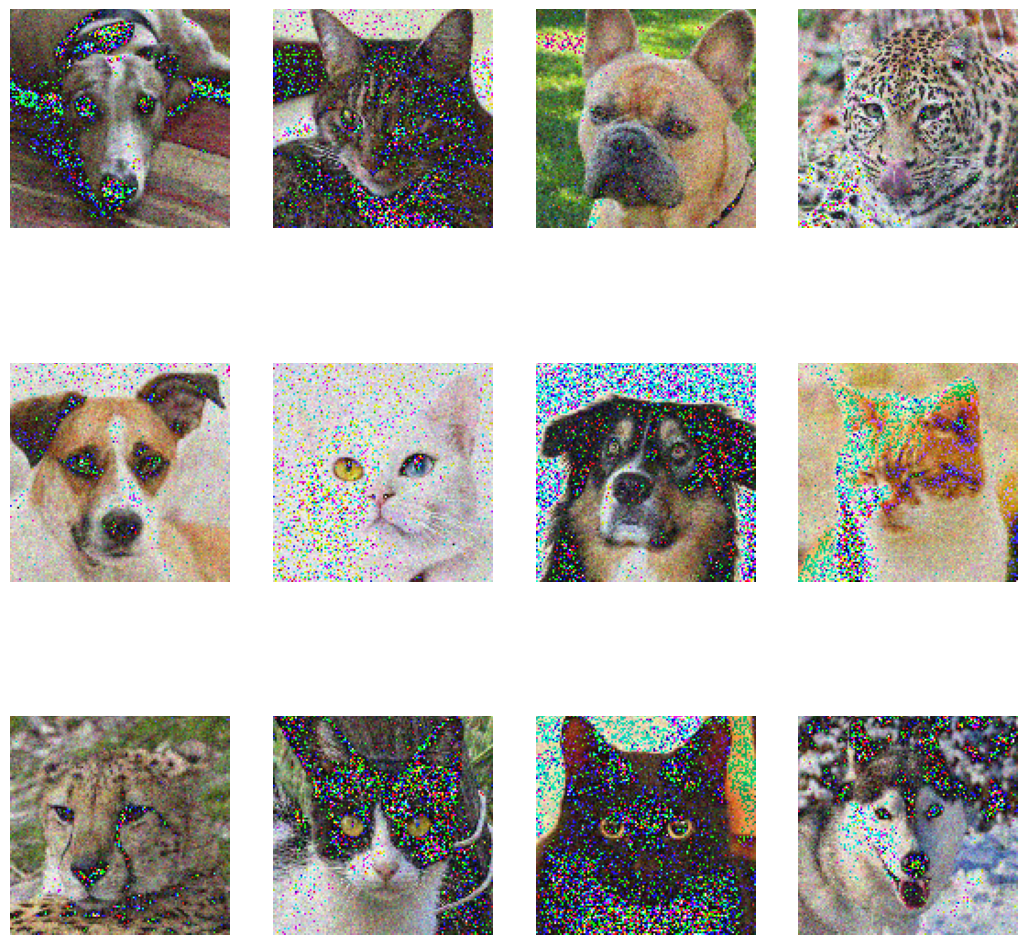

In [75]:
plt.figure(figsize = (13, 13))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    img_rgb = cv2.cvtColor((noisy_train[i] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

In [93]:
from torch.utils.data import DataLoader
import torch
from tqdm import trange
import torch.nn as nn
import torch.optim as optim

In [78]:
train_loader = DataLoader(noisy_train, batch_size = 64, shuffle = True)
valid_loader = DataLoader(noisy_valid, batch_size = 64, shuffle = False)
test_loader = DataLoader(noisy_test, batch_size = 64, shuffle = False)

In [80]:
for x in train_loader:
    print(f'Shape of X [N, H, W, C]: {x.shape}')
    break

Shape of X [N, H, W, C]: torch.Size([64, 120, 120, 3])


In [84]:
device = ('cuda' if torch.cuda.is_available()
         else 'mps' if torch.backends.mps.is_available()
         else 'cpu')
print(f'Using {device} device')

Using cuda device


In [81]:
def plot_results(train_losses, valid_losses):
    plt.figure(figsize = (7, 5))
    plt.plot(train_losses, label = 'Train', color = 'teal')
    plt.plot(valid_losses, label = 'Validation', color = 'orange')
    plt.title('Training loss vs Validation loss', fontsize = 15)
    plt.xlabel('Epoch', fontsize = 10)
    plt.ylabel('Loss', fontsize = 10)
    plt.legend()
    plt.show()

In [102]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    running_loss = 0
    model.train()
    for x in dataloader:
        x = x.permute(0, 3, 1, 2)
        x = x.float().to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, x)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

In [103]:
def valid_step(model, criterion, dataloader, device = device):
    running_loss = 0
    model.eval()
    with torch.no_grad():
        for x in dataloader:
            x = x.permute(0, 3, 1, 2)
            x = x.float().to(device)
            pred = model(x)
            running_loss += criterion(pred, x).item()
    return running_loss / len(dataloader)

In [104]:
def train_model(model, epochs, optimizer, train_loader, valid_loader, device = device):
    train_losses, valid_losses = [], []
    criterion = torch.nn.MSELoss()
    for epoch in (pbar := trange(epochs)):
        train_loss = train_step(model, criterion, optimizer, train_loader, device)
        valid_loss = valid_step(model, criterion, valid_loader, device)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        pbar.set_description(f'Train Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f}')
    plot_results(train_losses, valid_losses)
    return {'train_losses': train_losses, 'valid_losses': valid_losses}

In [107]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.Conv2d(128, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2, mode = 'nearest'),
            nn.Conv2d(128, 3, kernel_size = 2, padding = 1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.nn.functional.interpolate(x, size=(120, 120), mode='bilinear', align_corners=False)
        return x

Train Loss: 0.011 | Valid Loss: 0.011: 100%|██████████| 30/30 [17:29<00:00, 34.97s/it]


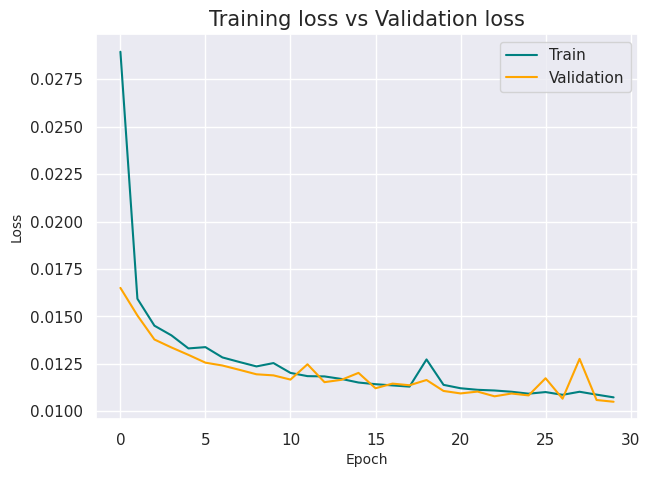

In [108]:
model = model().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 30, optimizer, train_loader, valid_loader)

In [115]:
criterion = nn.MSELoss()

In [116]:
test_loss = valid_step(model, criterion, test_loader, device = device)

In [118]:
print(f'Test Loss: {test_loss}')

Test Loss: 0.010691506018781143


In [120]:
model.eval()
with torch.no_grad():
    for x in test_loader:
        x = x.permute(0, 3, 1, 2)
        x = x.float().to(device)
        outputs = model(x)
        break

In [121]:
images_cpu = x.cpu()
output_cpu = outputs.cpu()

In [122]:
def show_images(orig, reconstructed, num_images = 5):
    plt.figure(figsize = (10, 4))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(orig[i].permute(1, 2, 0))
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].permute(1, 2, 0))
        plt.axis('off')
    plt.show()

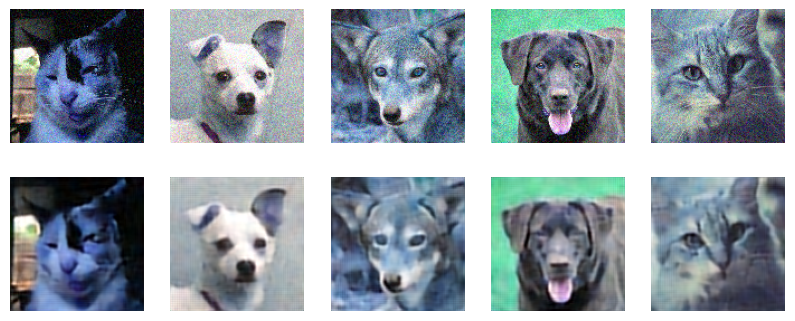

In [123]:
show_images(images_cpu, output_cpu, num_images = 5)